ECUACIÓN DE SCHRODINGER DEPENDIENTE DEL TIEMPO: MÉTODO DE CRANCK-NICOLSON, RENDIJA SIMPLE 2D.

In [10]:
import numpy as np
from scipy.sparse import diags, kron, identity
from scipy.sparse.linalg import splu
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl

Definición de constantes y parámetros de la simulación

In [11]:
# Constantes físicas
hbar = 1.0 # constante de Planck reducida
m = 1.0 # masa del electrón

# Parámetros espaciales
x_min, x_max = -5, 8 #límites del dominio eje x
y_min, y_max = -8, 8 #límites del dominio eje y
N = 150 #número de puntos espaciales
x = np.linspace(x_min, x_max, N) #discretización eje x
y = np.linspace(y_min, y_max, N) #discretización eje y

#paso espacial
dx = x[1] - x[0]
dy = y[1] - y[0]

#Generación de la malla
X, Y = np.meshgrid(x, y)

# Parámetros temporales
dt = 0.005 #paso temporal
t_max = 1.5 #tiempo máximo de simulación
Nt = int(t_max / dt) #número de puntos temporales

Definición del potencial y la función de onda inicial

In [12]:
# Potencial: pared vertical fina con rendija
V = np.zeros((N, N))
V[0, :] = V[-1, :] = V[:, 0] = V[:, -1] = 1e8  # Bordes "infinitos"

centro = N // 2
grosor_pared = 5      # Grosor de la pared vertical
ancho_rendija = 20    # Tamaño del agujero (rendija)

# Pared vertical central
V[:, centro - grosor_pared//2 : centro + grosor_pared//2] = 1e6
# Agujero en la pared (rendija)
V[N//2 - ancho_rendija//2 : N//2 + ancho_rendija//2, centro - grosor_pared//2 : centro + grosor_pared//2] = 0

V_vec = V.flatten()

# Centro inicial
x0 = -4.0   # un poco a la izquierda de la rendija
y0 = 0.0    # centro en Y

# Anchuras
sigma_x = 0.5  # ancho del frente en X (paquete delgado horizontalmente)
sigma_y = 3.0  # ancho en Y (no ocupa todo el dominio)
k0x = 8.0  # más rápido

# Frente de ondas inicial
psi0 = np.exp(-((X - x0)**2)/(2*sigma_x**2)) * np.exp(-((Y - y0)**2)/(2*sigma_y**2)) * np.exp(1j * k0x * X)

# Normalización
psi0 /= np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)






Construcción del Hamiltoniano

In [13]:
# Laplaciano discreto 2D
main_diag = -2*np.ones(N)
off_diag = np.ones(N-1)
D = diags([off_diag, main_diag, off_diag], [-1,0,1]) / dx**2
I = identity(N)
laplacian_2d = kron(D, I) + kron(I, D)

# Hamiltoniano
H = -(hbar**2/(2*m)) * laplacian_2d + diags(V_vec, 0)

Construcción Matrices Cranck-Nicolson y Factorización LU de la matriz A

In [14]:
# Matriz identidad
I2 = identity(N**2)

#Matrices CN
A = I2 + 1j*dt/(2*hbar)*H
B = I2 - 1j*dt/(2*hbar)*H

#Factorización LU de A para resolver sistemas de manera eficiente
A_lu = splu(A.tocsc())

Resolución de la ecuación y comprobamos la conservación de la norma

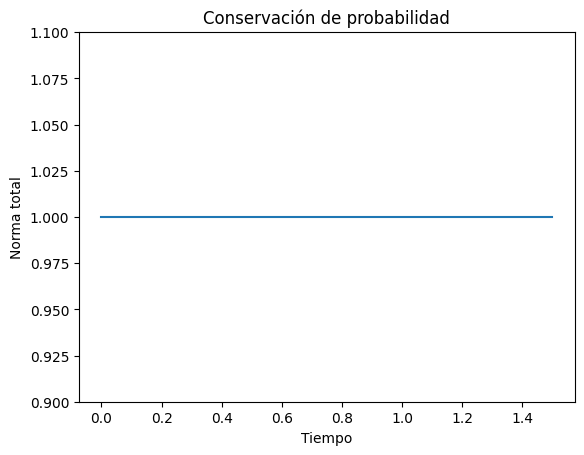

In [15]:
# Evolución temporal
psi_vec = psi0.flatten()
psi_t = [psi0.copy()]

for n in range(Nt):
    psi_vec = A_lu.solve(B.dot(psi_vec))
    psi_t.append(psi_vec.reshape(N,N))

# Comprobación de la norma
norms = [np.sum(np.abs(p)**2)*dx*dy for p in psi_t]
times = [n*dt for n in range(len(psi_t))]

plt.figure()
plt.plot(times, norms)
plt.xlabel('Tiempo')
plt.ylabel('Norma total')
plt.ylim([0.9, 1.1])
plt.title('Conservación de probabilidad')
plt.show()

Generamos la animación para mostrar la evolución de la densidad de probabilidad de la función de onda en el tiempo

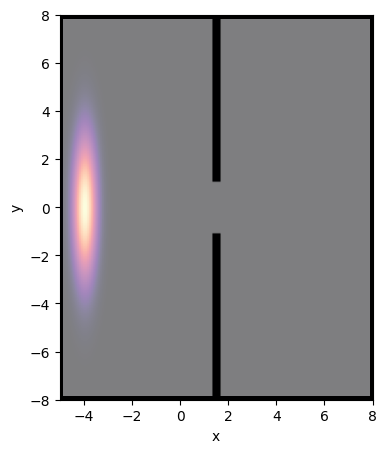

In [16]:

# Animación con visualización de la rendija 
mpl.rcParams['animation.embed_limit'] = 100*1024*1024
fig, ax = plt.subplots(figsize=(6,5))

# Muestra la densidad de probabilidad
im = ax.imshow(np.abs(psi_t[0])**2, extent=[x_min,x_max,y_min,y_max], origin='lower',
               cmap='magma', vmin=0, vmax=np.max(np.abs(psi_t[0])**2))

# Superponemos la pared con rendija (potencial) en gris semi-transparente
ax.imshow(V, extent=[x_min,x_max,y_min,y_max], origin='lower',
          cmap='Greys', alpha=0.5, vmin=0, vmax=1e6)

ax.set_xlabel('x')
ax.set_ylabel('y')
time_text = ax.text(0.65, 0.9, '', transform=ax.transAxes, color='white')

def animate(i):
    im.set_data(np.abs(psi_t[i])**2)
    time_text.set_text(f't = {i*dt:.2f}')
    return [im, time_text]

#ani = FuncAnimation(fig, animate, frames=len(psi_t), interval=50, blit=True)
#HTML(ani.to_jshtml())


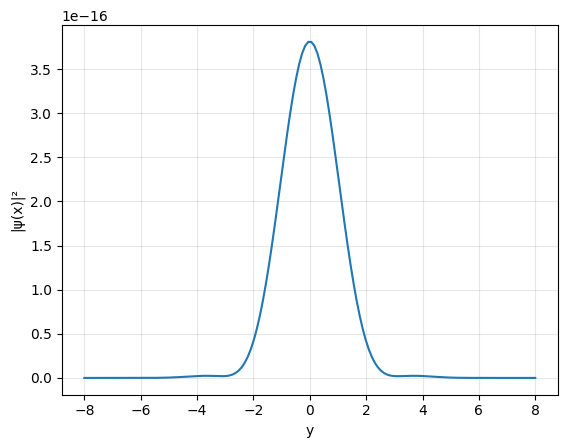

In [17]:
t_obs = 1.18  # tiempo que queremos observar
t_index = int(t_obs / dt)  # índice correspondiente en la lista psi_t

# Nos aseguramos de que no exceda el tamaño de psi_t
t_index = min(t_index, Nt)

# Columna de la "pantalla"
x_index = -1

# Densidad de probabilidad
prob_screen = np.abs(psi_t[t_index][:, x_index])**2

# Graficamos
plt.figure()
plt.plot(np.linspace(y_min, y_max, N), prob_screen)
plt.xlabel('y')
plt.ylabel('|ψ(x)|²')
plt.grid(alpha=0.3)
plt.show()

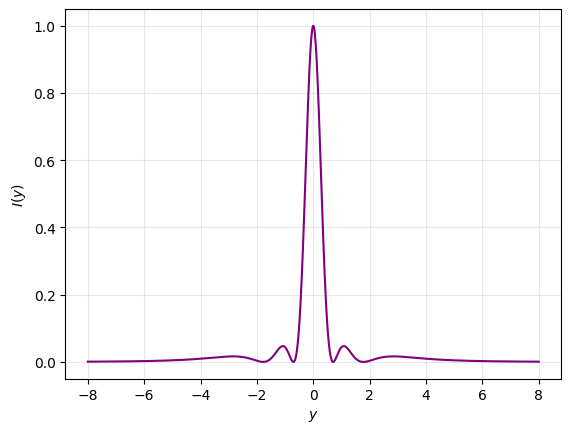

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros físicos
k0x = 15.0                # número de onda incidente
lambda_ = 2 * np.pi / k0x # longitud de onda asociada
b = 0.63                  # semialtura de la rendija (en tus unidades)
z = 2.0                   # distancia desde la rendija hasta la "pantalla"

# Eje y: posiciones en la pantalla
y = np.linspace(-8, 8, 1000)
theta = np.arctan(y / z)  # ángulo de difracción

# Intensidad analítica (difracción de Fraunhofer por rendija simple)
I = (np.sinc(k0x * b * np.sin(theta) / np.pi))**2  # np.sinc(x) = sin(pi*x)/(pi*x)

# Gráfica con el mismo formato que tus figuras anteriores
plt.figure()
plt.plot(y, I, color='purple')
plt.xlabel(r'$y$')
plt.ylabel(r'$I(y)$')
plt.grid(alpha=0.3)
plt.show()
